===== Mean proportion of smaller child =====
CART        : 0.135
Minimax     : 0.475
R1 purity   : 0.002
R2 extreme  : 0.016

===== % of runs classified as ECP (min child ≤ 5%) =====
CART        :  43.3 %
Minimax     :   0.0 %
R1 purity   : 100.0 %
R2 extreme  :  94.0 %


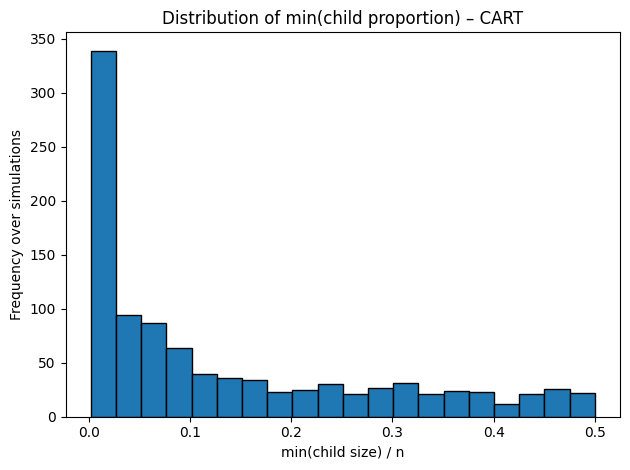

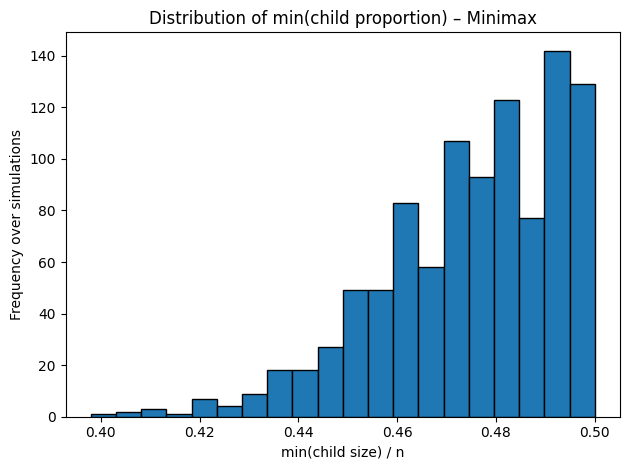

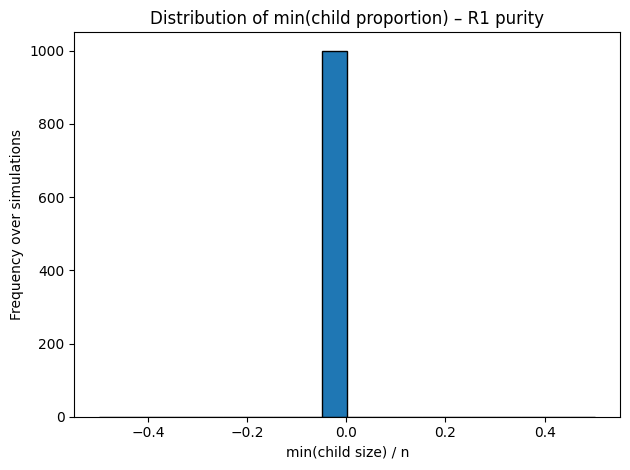

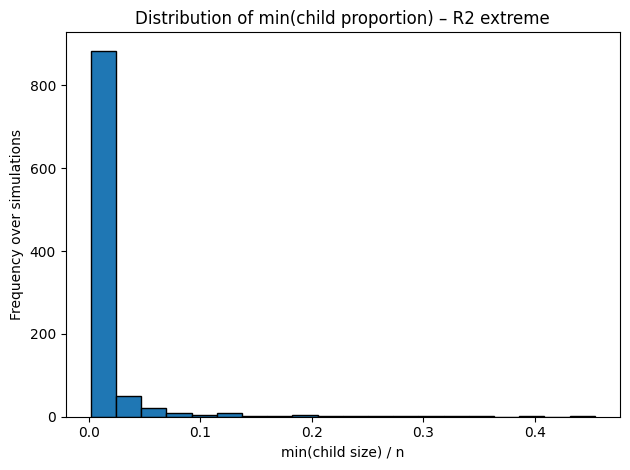

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_samples = 500          # size of each artificial dataset
n_rep      = 1000        # how many independent repetitions
edge_thr   = 0.05        # threshold that flags an "end-cut" (≤5 % of the data in one child)

rng = np.random.default_rng(20250801)

def best_split_CART(y):
    """Return proportion of the smaller child for usual CART (sum-of-squares) criterion."""
    n = len(y)
    # cumulative sums for fast mean / variance updates
    csum  = np.cumsum(y)
    csum2 = np.cumsum(y ** 2)
    best_score = np.inf
    best_min_prop = None
    
    for i in range(1, n):                          # split between i-1 and i
        nL, nR = i, n - i
        meanL  = csum[i-1] / nL
        meanR  = (csum[-1] - csum[i-1]) / nR
        varL   = (csum2[i-1] / nL) - meanL ** 2
        varR   = ((csum2[-1] - csum2[i-1]) / nR) - meanR ** 2
        score  = nL * varL + nR * varR
        if score < best_score:
            best_score = score
            best_min_prop = min(nL, nR) / n
    return best_min_prop

def best_split_minimax(y):
    """Return proportion of the smaller child for Minimax-variance criterion."""
    n = len(y)
    csum  = np.cumsum(y)
    csum2 = np.cumsum(y ** 2)
    best_score = np.inf
    best_min_prop = None
    
    for i in range(1, n):
        nL, nR = i, n - i
        meanL  = csum[i-1] / nL
        meanR  = (csum[-1] - csum[i-1]) / nR
        varL   = (csum2[i-1] / nL) - meanL ** 2
        varR   = ((csum2[-1] - csum2[i-1]) / nR) - meanR ** 2
        score  = max(nL * varL, nR * varR)
        if score < best_score:
            best_score = score
            best_min_prop = min(nL, nR) / n
    return best_min_prop

def best_split_R1(y):
    """Return proportion for KDD 'one-sided purity' = minimise min(varL,varR)."""
    n = len(y)
    csum  = np.cumsum(y)
    csum2 = np.cumsum(y ** 2)
    best_score = np.inf
    best_min_prop = None
    
    for i in range(1, n):
        nL, nR = i, n - i
        meanL  = csum[i-1] / nL
        meanR  = (csum[-1] - csum[i-1]) / nR
        varL   = (csum2[i-1] / nL) - meanL ** 2
        varR   = ((csum2[-1] - csum2[i-1]) / nR) - meanR ** 2
        score  = min(varL, varR)
        if score < best_score:
            best_score = score
            best_min_prop = min(nL, nR) / n
    return best_min_prop

def best_split_R2(y):
    """Return proportion for KDD 'one-sided extreme' = maximise max(meanL,meanR)."""
    n = len(y)
    csum  = np.cumsum(y)
    best_score = -np.inf
    best_min_prop = None
    
    for i in range(1, n):
        nL, nR = i, n - i
        meanL  = csum[i-1] / nL
        meanR  = (csum[-1] - csum[i-1]) / nR
        score  = max(meanL, meanR)                # maximise
        if score > best_score:
            best_score = score
            best_min_prop = min(nL, nR) / n
    return best_min_prop

# Simulation loop
results = {
    "CART": [],
    "Minimax": [],
    "R1 purity": [],
    "R2 extreme": []
}

for _ in range(n_rep):
    x  = rng.random(n_samples)           # predictor values (unused, but could sort)
    y  = rng.standard_normal(n_samples)  # pure noise response
    idx = np.argsort(x)
    y_sorted = y[idx]
    
    results["CART"].append(    best_split_CART(y_sorted))
    results["Minimax"].append( best_split_minimax(y_sorted))
    results["R1 purity"].append(best_split_R1(y_sorted))
    results["R2 extreme"].append(best_split_R2(y_sorted))

# Convert to numpy arrays for convenience
for k in results:
    results[k] = np.array(results[k])

# Print numeric summaries
print("===== Mean proportion of smaller child =====")
for k in results:
    print(f"{k:12s}: {results[k].mean():.3f}")

print("\n===== % of runs classified as ECP (min child ≤ 5%) =====")
for k in results:
    print(f"{k:12s}: {(results[k] <= edge_thr).mean()*100:5.1f} %")

# Histograms – one chart per criterion
for k in results:
    plt.figure()
    plt.hist(results[k], bins=20, edgecolor='black')
    plt.title(f"Distribution of min(child proportion) – {k}")
    plt.xlabel("min(child size) / n")
    plt.ylabel("Frequency over simulations")
    plt.tight_layout()
    plt.show()


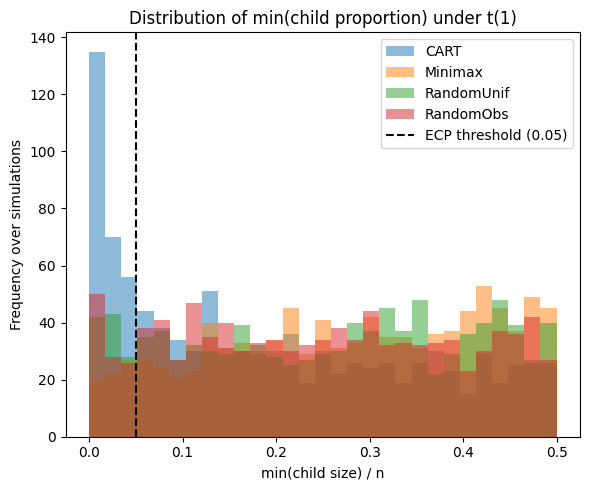

Mean min-child proportion:
CART      : 0.192  ECP%: 26.1%
Minimax   : 0.278  ECP%:  6.9%
RandomUnif: 0.255  ECP%: 11.3%
RandomObs : 0.245  ECP%: 10.4%


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_samples = 500          # size of each dataset
n_rep     = 1000         # number of repetitions
edge_thr  = 0.05         # ECP threshold

rng = np.random.default_rng(20250801)

def best_split_CART(y):
    n = len(y)
    csum, csum2 = np.cumsum(y), np.cumsum(y**2)
    best_score, best_prop = np.inf, None
    for i in range(1, n):
        nL, nR = i, n-i
        meanL = csum[i-1]/nL
        meanR = (csum[-1]-csum[i-1])/nR
        varL = csum2[i-1]/nL - meanL**2
        varR = (csum2[-1]-csum2[i-1])/nR - meanR**2
        score = nL*varL + nR*varR
        if score < best_score:
            best_score, best_prop = score, min(nL,nR)/n
    return best_prop

def best_split_minimax(y):
    n = len(y)
    csum, csum2 = np.cumsum(y), np.cumsum(y**2)
    best_score, best_prop = np.inf, None
    for i in range(1, n):
        nL, nR = i, n-i
        meanL = csum[i-1]/nL
        meanR = (csum[-1]-csum[i-1])/nR
        varL = csum2[i-1]/nL - meanL**2
        varR = (csum2[-1]-csum2[i-1])/nR - meanR**2
        score = max(nL*varL, nR*varR)
        if score < best_score:
            best_score, best_prop = score, min(nL,nR)/n
    return best_prop

def random_split_unif(x):
    """Pick a uniform cut in [min(x), max(x)] and return min child proportion."""
    n = len(x)
    cut = rng.uniform(x.min(), x.max())
    nL = np.searchsorted(x, cut, side='right')
    return min(nL, n-nL)/n

def random_split_obs(x):
    """Pick a random observed x-value as cut and return min child proportion."""
    n = len(x)
    cut = rng.choice(x)
    nL = np.searchsorted(x, cut, side='right')
    return min(nL, n-nL)/n

# Collect results
methods = {
    "CART":       lambda x,y: best_split_CART(y),
    "Minimax":    lambda x,y: best_split_minimax(y),
    "RandomUnif": lambda x,y: random_split_unif(x),
    "RandomObs":  lambda x,y: random_split_obs(x)
}

results = {k: [] for k in methods}

for _ in range(n_rep):
    x = rng.random(n_samples)
    #y = rng.standard_normal(n_samples)
    df_t = 1
    y = rng.standard_t(df_t, size=n_samples)
    order = np.argsort(x)
    x_sorted, y_sorted = x[order], y[order]
    for name, fn in methods.items():
        results[name].append(fn(x_sorted, y_sorted))

# Convert to arrays
for k in results:
    results[k] = np.array(results[k])

# Plot all four histograms in one panel
plt.figure(figsize=(6,5))
bins = np.linspace(0, 0.5, 30)
for name, vals in results.items():
    plt.hist(vals, bins=bins, alpha=0.5, label=name, density=False)
plt.axvline(edge_thr, color='k', linestyle='--', label=f"ECP threshold ({edge_thr})")
plt.title("Distribution of min(child proportion) under t(1)")
plt.xlabel("min(child size) / n")
plt.ylabel("Frequency over simulations")
plt.legend()
plt.tight_layout()
plt.show()

# Numeric summary
print("Mean min-child proportion:")
for name, vals in results.items():
    print(f"{name:10s}: {vals.mean():.3f}  ECP%: {(vals<=edge_thr).mean()*100:4.1f}%")


  Criterion  Avg leaf size mean  Avg leaf size variance  Avg depth  \
0      CART               5.151                   7.712      11.85   
1   Minimax               4.944                   1.178       8.57   
2        C1              15.841                2475.641      12.00   
3        C2               7.358                 192.796      12.00   

   Avg train MSE  Avg test  MSE  
0          0.006          0.016  
1          0.008          0.015  
2          0.159          0.160  
3          0.012          0.020  
0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.0 8
0.0 9
0.0 10
0.0 11
0.0 12
0.0 13
0.0 14
0.0 15
0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.01 11
0.01 12
0.01 13
0.01 14
0.01 15
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.05 10
0.05 11
0.05 12
0.05 13
0.05 14
0.05 15
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
0.1 11
0.1 12
0.1 13
0.1 14
0.1 15
1.0 0
1.0 1
1.0 2
1.0 3
1.0 4
1.0 5
1.0

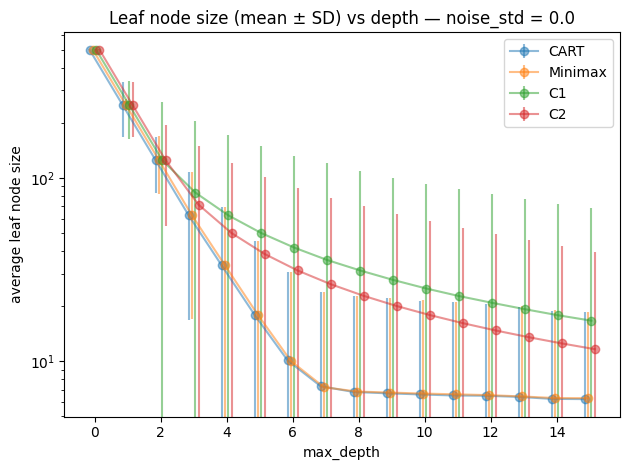

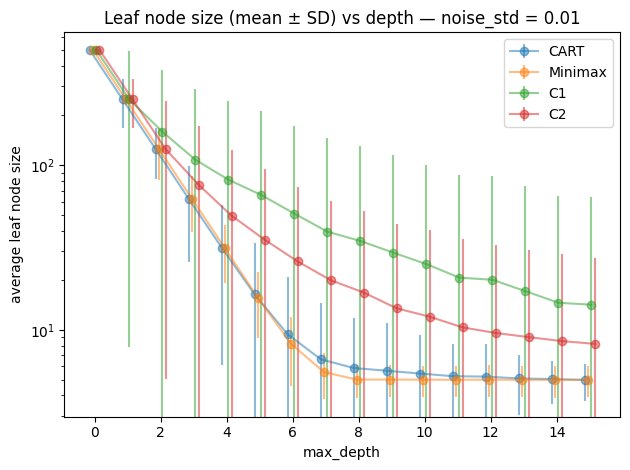

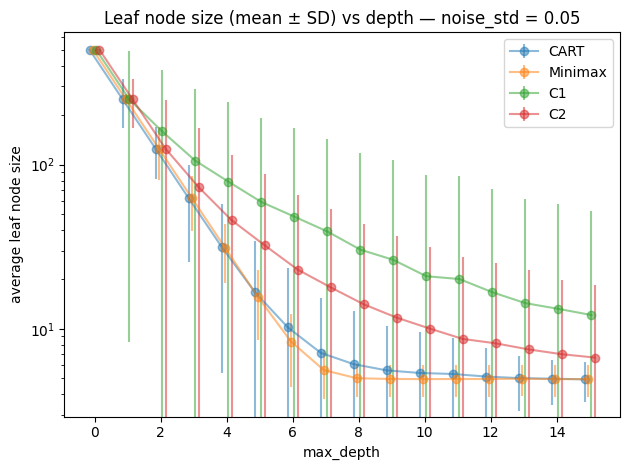

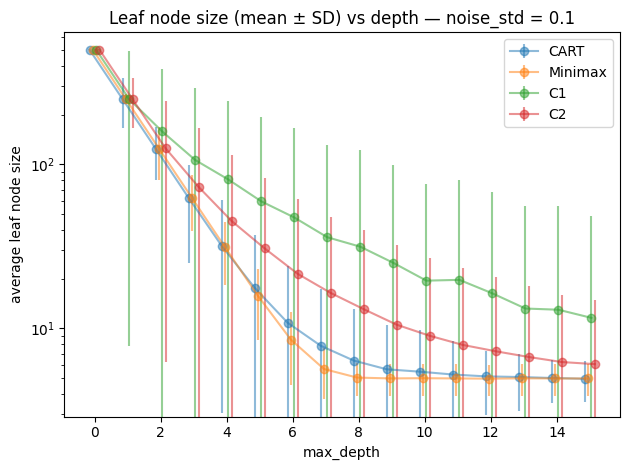

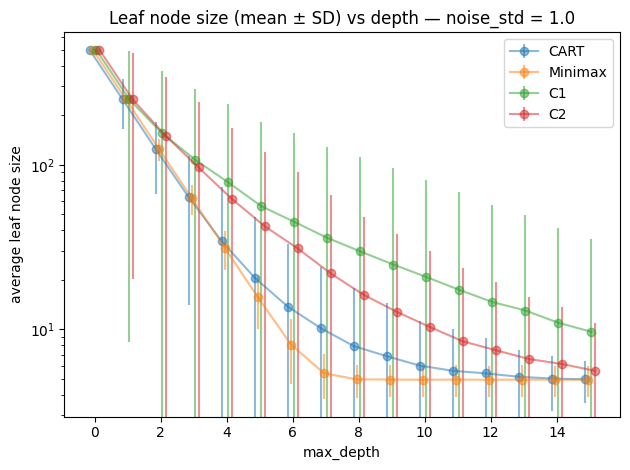

In [17]:
import numpy as np
from math import inf
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(20250801)

# ---------------------------------------------------------------------
# Splitting criteria helpers
# ---------------------------------------------------------------------
def _cum_stats(y):
    """Return cumulative sum and sumsq arrays."""
    csum  = np.cumsum(y)
    csum2 = np.cumsum(y**2)
    return csum, csum2

def _node_stats(csum, csum2, i, n):
    """return (nL,nR, meanL,meanR, varL,varR) for split after index i-1"""
    nL, nR = i, n - i
    meanL = csum[i-1] / nL
    meanR = (csum[-1] - csum[i-1]) / nR
    varL = max(0.0, csum2[i-1]/nL - meanL**2)
    varR = max(0.0, (csum2[-1]-csum2[i-1])/nR - meanR**2)
    return nL, nR, meanL, meanR, varL, varR

def best_split_sorted(y_sorted, min_leaf, criterion):
    """
    Given y already sorted by x, return split index & score.
    criterion in {'cart','minimax','C1','C2'}
    """
    n = len(y_sorted)
    csum, csum2 = _cum_stats(y_sorted)
    best_idx = None
    best_score = inf if criterion != 'C2' else -inf
    
    for i in range(min_leaf, n - min_leaf + 1):
        nL, nR, meanL, meanR, varL, varR = _node_stats(csum, csum2, i, n)
        if criterion == 'cart':
            score = nL*varL + nR*varR
            better = score < best_score
        elif criterion == 'minimax':
            score = max(nL*varL, nR*varR)
            better = score < best_score
        elif criterion == 'C1':
            score = min(varL, varR)
            better = score < best_score
        else:  # C2 maximise
            score = max(meanL, meanR)
            better = score > best_score
        if better:
            best_score = score
            best_idx = i
    return best_idx, best_score

# ---------------------------------------------------------------------
# Simple binary regression tree for a single continuous feature
# ---------------------------------------------------------------------
class TreeNode:
    __slots__ = ('is_leaf','pred','split_val','left','right','depth','indices')
    def __init__(self, indices, depth):
        self.is_leaf = True
        self.pred = None
        self.split_val = None
        self.left = None
        self.right = None
        self.depth = depth
        self.indices = indices

class SimpleTree:
    def __init__(self, criterion='cart', min_leaf=10, max_depth=6):
        self.criterion = criterion
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.root = None
    
    def fit(self, X, y):
        n = len(y)
        order = np.argsort(X)
        self.X_sorted = X[order]
        self.y_sorted = y[order]
        self.order = order
        self.root = self._build(indices=np.arange(n), depth=0)
    
    def _build(self, indices, depth):
        node = TreeNode(indices, depth)
        y_node = self.y_sorted[indices]
        node.pred = y_node.mean()
        
        # stopping rules
        if depth >= self.max_depth:
            return node
        if len(indices) < 2*self.min_leaf:
            return node
        
        # find best split among allowed positions
        local_idx_sorted = indices  # indices into y_sorted
        # translate local split index to global
        split_idx_local, _ = best_split_sorted(self.y_sorted[local_idx_sorted], self.min_leaf, self.criterion)
        if split_idx_local is None:
            return node
        
        node.is_leaf = False
        split_global_idx = local_idx_sorted[split_idx_local]
        # split value midway between X_sorted[split_global_idx-1], X_sorted[split_global_idx]
        left_mask = local_idx_sorted < split_global_idx
        right_mask = ~left_mask
        left_indices = local_idx_sorted[left_mask]
        right_indices = local_idx_sorted[right_mask]
        node.split_val = (self.X_sorted[split_global_idx-1] + self.X_sorted[split_global_idx]) / 2.0
        node.left  = self._build(left_indices,  depth+1)
        node.right = self._build(right_indices, depth+1)
        return node

    def _predict_one(self, x, node):
        if node.is_leaf:
            return node.pred
        if x <= node.split_val:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)
    
    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X])
    
    def leaf_sizes(self):
        return self._collect_leaf_sizes(self.root)
    
    def _collect_leaf_sizes(self, node):
        if node.is_leaf:
            return [len(node.indices)]
        return self._collect_leaf_sizes(node.left) + self._collect_leaf_sizes(node.right)
    
    def depth(self):
        return self._max_depth(self.root)
    
    def _max_depth(self, node):
        if node.is_leaf:
            return node.depth
        return max(self._max_depth(node.left), self._max_depth(node.right))

# ---------------------------------------------------------------------
# Experiment parameters
# ---------------------------------------------------------------------
n_train = 500
n_test  = 500
noise_std = 0.1
n_rep   = 100
min_leaf = 4
max_depth = 12

def true_function(x):
    # piecewise constant signal
    return np.where(x < 1/3, np.sin(x), np.where(x < 2/3, -2*x, 0.0))

criteria = {'CART':'cart','Minimax':'minimax','C1':'C1','C2':'C2'}
results = {k: {'leaf_mean':[],'leaf_var':[], 'depth':[], 'mse_train':[], 'mse_test':[]} for k in criteria}

# ---------------------------------------------------------------------
# Simulation loop
# ---------------------------------------------------------------------
for rep in range(n_rep):
    X_train = rng.random(n_train)
    y_train = true_function(X_train) + rng.normal(0, noise_std, n_train)
    X_test  = rng.random(n_test)
    y_test  = true_function(X_test) + rng.normal(0, noise_std, n_test)
    
    for label, crit in criteria.items():
        tree = SimpleTree(criterion=crit, min_leaf=min_leaf, max_depth=max_depth)
        tree.fit(X_train, y_train)
        # metrics
        leaf_sizes = np.array(tree.leaf_sizes())
        leaf_mean = leaf_sizes.mean()
        leaf_variance = leaf_sizes.var()
        depth = tree.depth()
        yhat_train = tree.predict(X_train)
        yhat_test  = tree.predict(X_test)
        mse_train = np.mean((y_train - yhat_train)**2)
        mse_test  = np.mean((y_test - yhat_test)**2)
        
        res = results[label]
        res['leaf_mean'].append(leaf_mean)
        res['leaf_var'].append(leaf_variance)
        res['depth'].append(depth)
        res['mse_train'].append(mse_train)
        res['mse_test'].append(mse_test)

# ---------------------------------------------------------------------
# Aggregate
# ---------------------------------------------------------------------
summary = []
for label in criteria:
    res = results[label]
    summary.append({
        'Criterion': label,
        'Avg leaf size mean': np.mean(res['leaf_mean']),
        'Avg leaf size variance': np.mean(res['leaf_var']),
        'Avg depth': np.mean(res['depth']),
        'Avg train MSE': np.mean(res['mse_train']),
        'Avg test  MSE': np.mean(res['mse_test']),
    })

df = pd.DataFrame(summary)
print(df.round(3))
# ---------------------------------------------------------------------
# Revised experiment grid
# ---------------------------------------------------------------------
n_train   = 500
n_test    = 500
noise_grid = [0.0, 0.01, 0.05, 0.1, 1.0]      # 5 noise levels
depth_grid = list(range(0, 16))               # max_depth = 0 … 15
n_rep      = 100                              # repetitions per cell
min_leaf   = 4

criteria = {'CART':    'cart',
            'Minimax': 'minimax',
            'C1':      'C1',
            'C2':      'C2'}

# ---------------------------------------------------------------------
# Storage: one long table that we aggregate later
# ---------------------------------------------------------------------
records = []

# ---------------------------------------------------------------------
# Outer loops over noise σ and max_depth
# ---------------------------------------------------------------------
for noise_std in noise_grid:
    for max_depth in depth_grid:
        print(noise_std,max_depth)
        for rep in range(n_rep):
            # --- generate one train/test split -----------------------
            X_train = rng.random(n_train)
            y_train = true_function(X_train) + rng.normal(0, noise_std, n_train)
            X_test  = rng.random(n_test)
            y_test  = true_function(X_test)  + rng.normal(0, noise_std, n_test)

            # --- fit a tree for each splitting rule -----------------
            for label, crit in criteria.items():
                tree = SimpleTree(criterion=crit,
                                  min_leaf=min_leaf,
                                  max_depth=max_depth)
                tree.fit(X_train, y_train)

                # --- collect statistics -----------------------------
                leaf_sizes  = np.array(tree.leaf_sizes())
                yhat_train  = tree.predict(X_train)
                yhat_test   = tree.predict(X_test)

                records.append({
                    "criterion" : label,
                    "noise_std" : noise_std,
                    "max_depth" : max_depth,
                    "leaf_mean" : leaf_sizes.mean(),
                    "leaf_var"  : leaf_sizes.var(),
                    "tree_depth": tree.depth(),
                    "mse_train" : np.mean((y_train - yhat_train)**2),
                    "mse_test"  : np.mean((y_test  - yhat_test )**2)
                })

# ---------------------------------------------------------------------
# Turn the long list into a DataFrame
# ---------------------------------------------------------------------
df = pd.DataFrame.from_records(records)

# ---------------------------------------------------------------------
# Aggregate: average over the n_rep repetitions in each (σ, depth, criterion) cell
# ---------------------------------------------------------------------
summary = (df
           .groupby(["criterion", "noise_std", "max_depth"], as_index=False)
           .agg({"leaf_mean":"mean",
                 "leaf_var" :"mean",
                 "tree_depth":"mean",
                 "mse_train":"mean",
                 "mse_test" :"mean"}))

# Optional: save or inspect
# summary.to_csv("split_rule_grid_results.csv", index=False)
print(summary.head(12))      # first few rows just to spot-check
import pandas as pd
import matplotlib.pyplot as plt

# Load aggregated results from the uploaded CSV
df = pd.read_csv('ECP.csv').drop(columns=['Unnamed: 0'])

noise_vals = [0.0, 0.01, 0.05, 0.1, 1.0]
methods = ["CART", "Minimax", "C1", "C2"]

# Make one plot per noise level (guideline: one chart per figure, no subplots)
for noise in noise_vals:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    m_ct = 0
    for method in methods:
        
        sub = df[(df["noise_std"] == noise) & (df["criterion"] == method)]
        ax.errorbar(
            sub["max_depth"]+(m_ct-1.5)*0.1,
            sub["leaf_mean"],
            yerr=sub["leaf_var"]**0.5,            # bar = √variance
            label=method,
            marker='o',
            linestyle='-',
            alpha=0.5
        )
        m_ct=m_ct+1
        # annotate with training / testing MSE
        #for ii, row in sub.iterrows():
        #    ax.annotate(
        #        f"{row['mse_train']:.3f}\n/{row['mse_test']:.3f}",
        #        (row["max_depth"], row["leaf_mean"]),
        #        textcoords="offset points",
        #        xytext=(0, ii+5),
        #        ha='center',
        #        fontsize=6,
        #        rotation=90
        #    )
    
    ax.set_xlabel("max_depth")
    ax.set_ylabel("average leaf node size")
    ax.set_yscale("log")
    ax.set_title(f"Leaf node size (mean ± SD) vs depth — noise_std = {noise}")
    ax.legend()
    plt.tight_layout()
    plt.show()